In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# The Problem
*****
- To detect breast cancer from radiological scans, specifically the presence of clusters of microcalcifications that appear bright on a mammogram.
- Dataset from: Woods, Kevin S., et al. "Comparative evaluation of pattern recognition techniques for detection of microcalcifications in mammography." State of The Art in Digital Mammographic Image Analysis. 1994. 213-231 [link](https://www.worldscientific.com/doi/abs/10.1142/9789812797834_0011).

# Dataset
*****
Features 
- Area of object (in pixels).
- Average gray level of the object.
- Gradient strength of the object’s perimeter pixels.
- Root mean square noise fluctuation in the object.
- Contrast, average gray level of the object minus the average of a two-pixel wide border surrounding the object.
- A low order moment based on shape descriptor.

Classes:
- Non-microcalcifications: negative case, or majority class.
- Microcalcifications: positive case, or minority class.

In [2]:
df = pd.read_csv("../data/mammography.csv", header=None)

In [3]:
df.head()

,0,1,2,3,4,5,6
0,0.230020,5.072578,-0.276061,0.832444,-0.377866,0.480322,'-1'
1,0.155491,-0.169390,0.670652,-0.859553,-0.377866,-0.945723,'-1'
2,-0.784415,-0.443654,5.674705,-0.859553,-0.377866,-0.945723,'-1'
3,0.546088,0.131415,-0.456387,-0.859553,-0.377866,-0.945723,'-1'
4,-0.102987,-0.394994,-0.140816,0.979703,-0.377866,1.013566,'-1'


In [4]:
df.describe()

,0,1,2,3,4,5
count,1.118300e+04,1.118300e+04,1.118300e+04,1.118300e+04,1.118300e+04,1.118300e+04
mean,1.096536e-10,1.297595e-09,5.698113e-10,-2.435706e-09,-1.120680e-09,1.459483e-09
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-7.844148e-01,-4.701953e-01,-5.916315e-01,-8.595525e-01,-3.778657e-01,-9.457232e-01
25%,-7.844148e-01,-4.701953e-01,-5.916315e-01,-8.595525e-01,-3.778657e-01,-9.457232e-01
50%,-1.085769e-01,-3.949941e-01,-2.309790e-01,-8.595525e-01,-3.778657e-01,-9.457232e-01
75%,3.139489e-01,-7.649473e-02,2.198366e-01,8.202077e-01,-3.778657e-01,1.016613e+00
max,3.150844e+01,5.085849e+00,2.947777e+01,9.591164e+00,2.361712e+01,1.949027e+00


In [5]:
df.columns =['Area_Obj', 'Avg_Gray', 'Grad', 'RMS', "Cont", 'Momentum', "Class"]

In [6]:
mask_positive = df["Class"] == "'1'"
mask_negative = ~mask_positive

In [7]:
mask_positive.sum()

260

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11183 entries, 0 to 11182
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Area_Obj  11183 non-null  float64
 1   Avg_Gray  11183 non-null  float64
 2   Grad      11183 non-null  float64
 3   RMS       11183 non-null  float64
 4   Cont      11183 non-null  float64
 5   Momentum  11183 non-null  float64
 6   Class     11183 non-null  object 
dtypes: float64(6), object(1)
memory usage: 611.7+ KB


In [9]:
mask_negative.sum()

10923

In [10]:
df["Class"][mask_positive] = 1

<ipython-input-10-35833cdeaf02>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Class"][mask_positive] = 1


In [11]:
df["Class"][mask_negative] = 0

<ipython-input-11-ab7cd0acf4ba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Class"][mask_negative] = 0


In [12]:
df['Class'].astype(int)

0        0
1        0
2        0
3        0
4        0
        ..
11178    1
11179    1
11180    1
11181    1
11182    1
Name: Class, Length: 11183, dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11183 entries, 0 to 11182
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Area_Obj  11183 non-null  float64
 1   Avg_Gray  11183 non-null  float64
 2   Grad      11183 non-null  float64
 3   RMS       11183 non-null  float64
 4   Cont      11183 non-null  float64
 5   Momentum  11183 non-null  float64
 6   Class     11183 non-null  object 
dtypes: float64(6), object(1)
memory usage: 611.7+ KB


### Imbalanced data

In [14]:
df["Class"].value_counts()

0    10923
1      260
Name: Class, dtype: int64

In [15]:
def show_null(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    display(missing_data)
show_null(df)

,Total,Percent
Area_Obj,0,0.0
Avg_Gray,0,0.0
Grad,0,0.0
RMS,0,0.0
Cont,0,0.0
Momentum,0,0.0
Class,0,0.0


### Correlation matrix

Text(0.5, 1.0, 'Correlation Heatmap')

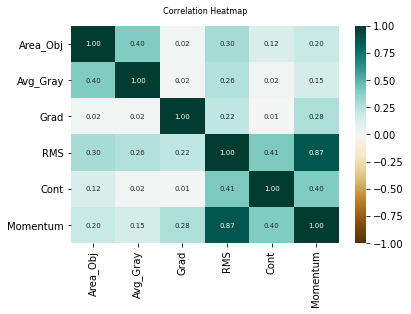

In [16]:
corr_matrix = df.corr()
plt.figure()
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap='BrBG', annot = True, fmt=".2f", annot_kws={"size":7})
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':8}, pad=12)

### Variables dependence

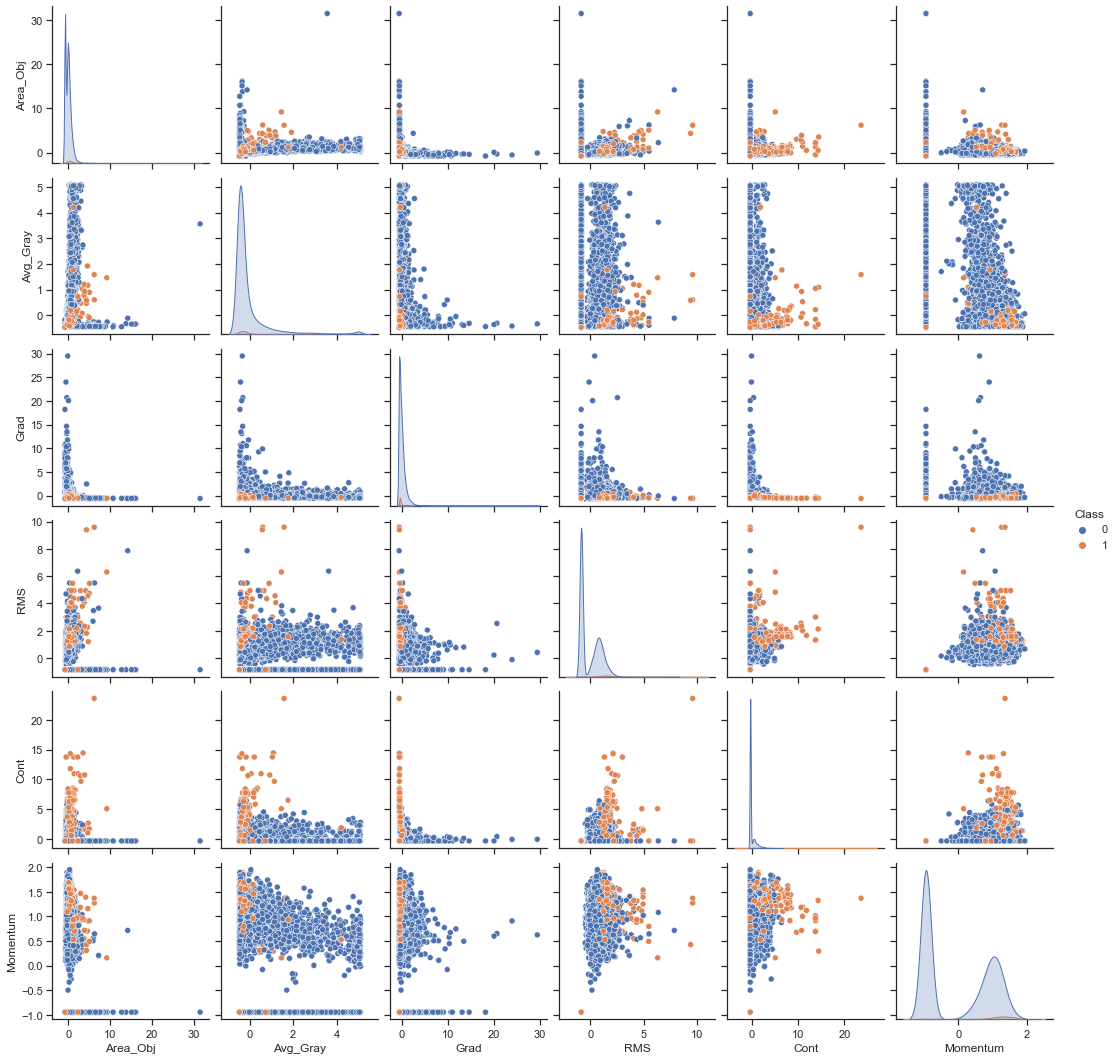

In [17]:
def show_pair_plots(df):
    sns.set(style="ticks", color_codes=True)
    sns.pairplot(df,vars = ['Area_Obj', 'Avg_Gray', 'Grad', 'RMS', "Cont", 'Momentum'], hue="Class")
    plt.show()
show_pair_plots(df)

# Classification
*****

In [18]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Classification with imbalanced data

In [19]:
y = df["Class"]
X = df.iloc[:,0:6]

In [20]:
y = y.astype(int)

In [21]:
y

0        0
1        0
2        0
3        0
4        0
        ..
11178    1
11179    1
11180    1
11181    1
11182    1
Name: Class, Length: 11183, dtype: int64

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [23]:
 df['Class'].astype(str).astype(int)

0        0
1        0
2        0
3        0
4        0
        ..
11178    1
11179    1
11180    1
11181    1
11182    1
Name: Class, Length: 11183, dtype: int64

In [24]:
(y_train == 1).sum()

207

In [25]:
(y_test == 1).sum()

53

### Gradient Boosting Classifier

In [26]:
def classif_model(X_train, y_train):
    clf = GradientBoostingClassifier(n_estimators=100, max_depth=1)
    clf.fit(X_train, y_train)
    return clf


def prediction(X_test,clf):
    y_pred_prob = clf.predict_proba(X_test)

    y_pred = clf.predict(X_test)
    
    return y_pred_prob, y_pred


clf = classif_model(X_train,y_train)
y_pred_prob, y_pred = prediction(X_test,clf)    

### Performance Metrics

F1: 0.53  -- prec: 0.78  -- recall: 0.40  -- acc: 0.98


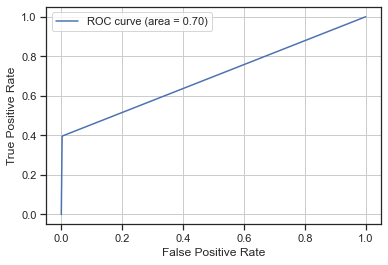

,0,1,accuracy,macro avg,weighted avg
precision,0.985520,0.777778,0.983013,0.881649,0.980598
recall,0.997253,0.396226,0.983013,0.696740,0.983013
f1-score,0.991352,0.525000,0.983013,0.758176,0.980303
support,2184.000000,53.000000,0.983013,2237.000000,2237.000000


In [27]:
def show_metrics(y_test, y_pred):
    fpr, tpr, ths = roc_curve(y_test,  y_pred)
    auc_ = auc(fpr, tpr)
    f1 = f1_score(y_test,  (y_pred>.5))
    prec = precision_score(y_test,  (y_pred>.5))
    rec = recall_score(y_test,  (y_pred>.5))
    acc = accuracy_score(y_test,  (y_pred>.5))
    print("F1: %.2f" %f1 , " -- prec: %.2f" %prec, " -- recall: %.2f" %rec, " -- acc: %.2f" %acc)
    
    cm = confusion_matrix(y_test, y_pred)

    plt.plot(fpr,tpr, label='ROC curve (area = %.2f)' %auc_)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()
    d = classification_report(y_test, y_pred,output_dict=True)
    display(pd.DataFrame.from_dict(d))
    
    
show_metrics(y_test, y_pred)

### Balanced Data with oversampling

In [28]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
df_resampled, y_resampled = ros.fit_resample(X, y)

In [29]:
df_res = df_resampled.copy()

In [30]:
df_res["Class"] = y_resampled

In [31]:
df_res

,Area_Obj,Avg_Gray,Grad,RMS,Cont,Momentum,Class
0,0.230020,5.072578,-0.276061,0.832444,-0.377866,0.480322,0
1,0.155491,-0.169390,0.670652,-0.859553,-0.377866,-0.945723,0
2,-0.784415,-0.443654,5.674705,-0.859553,-0.377866,-0.945723,0
3,0.546088,0.131415,-0.456387,-0.859553,-0.377866,-0.945723,0
4,-0.102987,-0.394994,-0.140816,0.979703,-0.377866,1.013566,0
...,...,...,...,...,...,...,...
21841,1.097430,-0.191508,-0.501468,2.255240,6.067727,1.415784,1
21842,0.521866,-0.377300,-0.276061,1.840891,1.928619,1.287805,1
21843,0.818287,0.255275,-0.501468,1.749329,5.810613,1.421878,1
21844,1.265627,0.286241,0.219837,-0.859553,-0.377866,-0.945723,1


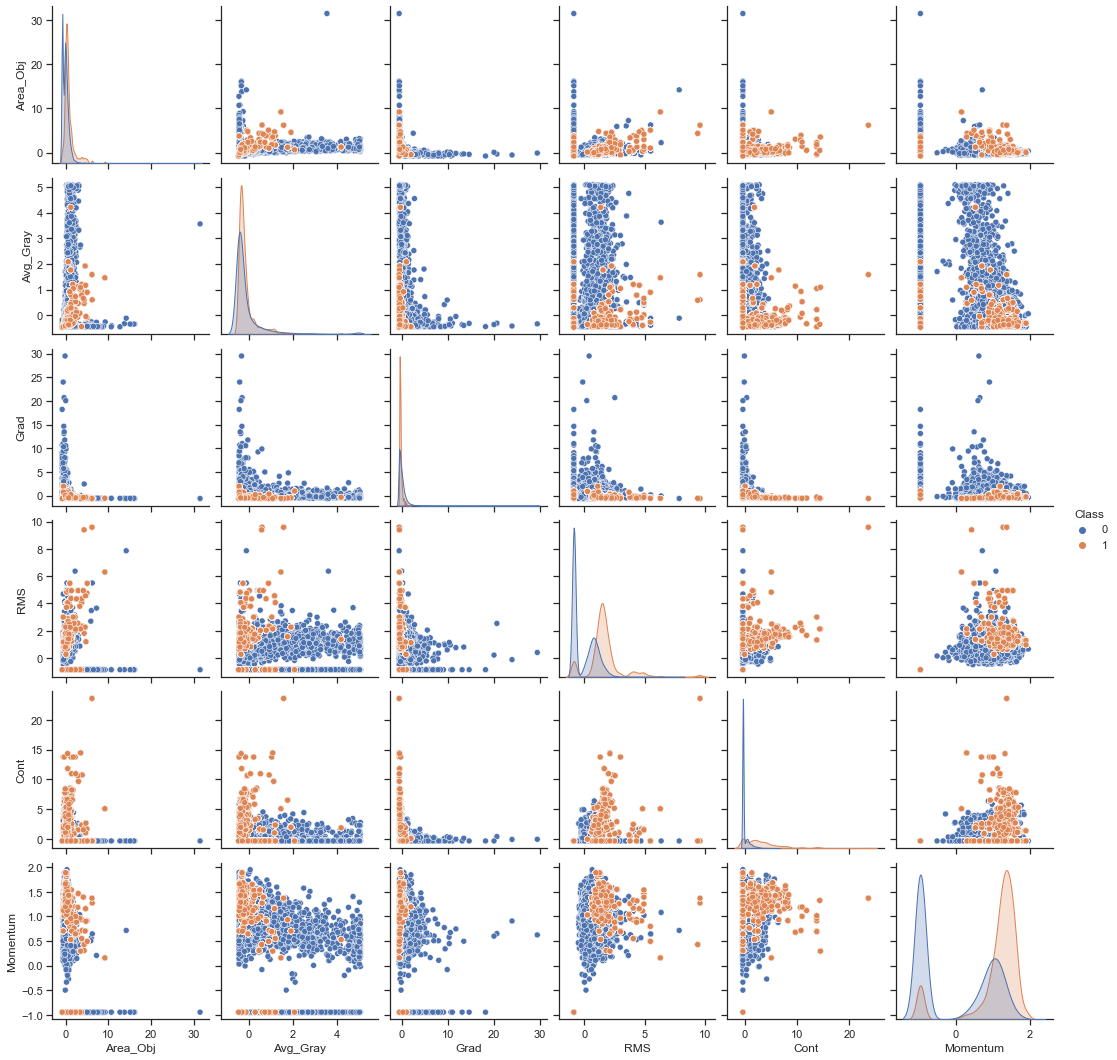

In [32]:
show_pair_plots(df_res)


In [33]:
y_res = df_res["Class"]
X_res = df_res.iloc[:,0:6]


X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res,y_res, test_size=0.2, random_state=0)

clf_2 = classif_model(X_train_res, y_train_res)

### Balanced testing set
Is it correct to balance the testing set?

F1: 0.90  -- prec: 0.92  -- recall: 0.87  -- acc: 0.90


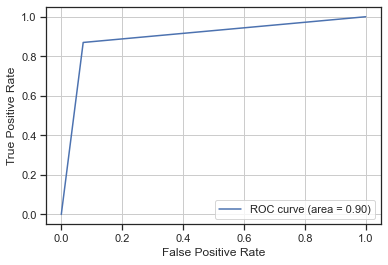

,0,1,accuracy,macro avg,weighted avg
precision,0.879503,0.921982,0.899314,0.900742,0.900499
recall,0.928054,0.869907,0.899314,0.898981,0.899314
f1-score,0.903126,0.895188,0.899314,0.899157,0.899203
support,2210.000000,2160.000000,0.899314,4370.000000,4370.000000


In [34]:
y_pred_prob_res , y_pred_res = prediction(X_test_res, clf_2)
show_metrics(y_test_res, y_pred_res)

### Imbalanced testing set

F1: 0.38  -- prec: 0.24  -- recall: 0.92  -- acc: 0.93


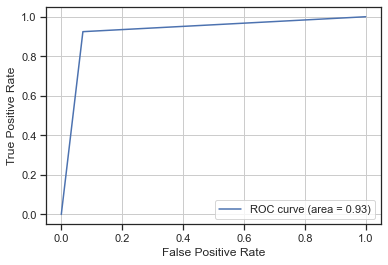

,0,1,accuracy,macro avg,weighted avg
precision,0.998032,0.240196,0.928923,0.619114,0.980077
recall,0.929029,0.924528,0.928923,0.926779,0.928923
f1-score,0.962295,0.381323,0.928923,0.671809,0.948531
support,2184.000000,53.000000,0.928923,2237.000000,2237.000000


In [35]:
y_pred_prob_res , y_pred_res = prediction(X_test, clf_2)
show_metrics(y_test, y_pred_res)